In [103]:
import os
import sys
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from copy import deepcopy
import numpy as np
import scipy.stats as stats
from sklearn import preprocessing, linear_model
from sklearn.model_selection import KFold
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils import check_array
from sklearn import model_selection

In [104]:
def kfold_feature_learning(train, test, y, t_y, clf = linear_model.LassoCV(cv=10), problem = 'regression', 
                           folds = 10, scale=True, verbose = True, search = False,
                           p_cutoff = None, regcols = None, regdf = None, keep_cols = None, 
                           out_dir = None,  output='light', save_int = True):
    '''
    This is a function that will use nested cross validation to generate an average model
    that will hopefully generalize better to unseen test data. 
    
    You can must your training and testing data, and your y variable for both, the model you 
    wish to use for  prediction, and whether the problem is classification or regression.
    
    The function will run K iterations of prediction on your training set, and will average 
    the weights across folds for a final model. The final model will then be applied to your 
    testing data. The validation and testing accuracy will be displayed. 
    
    Several other options exists (see below), and are forthcoming.
    
    ATTENTION: THIS SCRIPT IS STILL IN DEVELOPMENT. IT IS UGLY AND UNFINISHED, SO DONT JUDGE
    
    
    *** USER-DEFINED ARGUMENTS ***
    
    -- train is a subjects x variables dataframe (this represents your training data)
    -- y is a pandas series with the same index as train. y should not be in train
    
    # NOTE: train and test indices should just be a range
    
    -- test is a subjects x variables dataframe (this represents your independent test data)
    -- t_y is a pandas seris with the same index as test. y should not be in tets

    
    *** MODEL OPTIONS ***

    -- clf: here, you can put in whatever model you want with whatever parameters you want.
    
    -- if your model (clf) is a regression model (e.g. Lasso, SVR), leave problem as "regression". 
    If it is a classification model (e.g. SVM, SGD, etc.), change problem to "classification"
    
    -- folds: how many fold cross-validation should occur within the outer loop of the t
    raining dataset
    
    -- scale: if True, train will be scaled with a Standard Scaler, and test will be transformed 
    to this scale
    
    -- verbose: if you do not want any output (including scores at the end!!), set this to False.
    
    -- search: if clf is a model_selector (such as GridSearch), MAKE SURE you set this to True,
    or the script will fail.
    
    
    *** FEATURE SELECTION OPTIONS ***
    
    -- p_cutoff: if you wish to only keep features statistically related to y (through t-test 
    or correlation), you can control the alpha value here. Leave as None to use all features
    
    -- reg_cols: a list of column labels in regdf. All labels specified in this list will be 
    regressed out of all other model features during "feature selection" (i.e. when features are
    removed via the p_cutoff argument). In other words, this argument can be used if you only
    want to include features in your model that are singificant when adjusting for the variables
    specified in reg_cols. Leave as None if you don't want this argument active.
    
    -- regdf: a subject x variables pandas Dataframe that contain anything as long as it has all 
    (matched) indices in train, and all columns in reg_cols
    
    -- keep_cols: a list of column labels. These are variables in train that you wish to retain 
    in your model no matter what, even if they do not pass the feature selection. For example, if
    age is not selected by your p_cutoff, but you still want age in your model, you can list in
    keep_cols
    
    *** OUTPUT OPTIONS ***
    
    -- out_dir: will save your weight matrix and predicted values to a directory you specify
    
    -- output: decide what you want the function to return:
        * 'scores' will only return the r2 (regression) or sensitivity, specificity and accuracy
            of you validation and test.
        * 'light' will return the weights of your final model, the predicted values of your
            validation, the predicted values of your test, and the intercept of the final model, 
            in that order.
        * 'heavy' if problem = regression, will return everything from light, plus a matrix 
            containing weights from all folds of the validations. Will also return the model 
            from the most recent fold.
            if problem = classification, will return a summary dataframe (with weights) for your
            validation, a summary dataframe for your test, your predicted values from validation,
            predicted values from test, a matrix containing weights from all folds of the 
            validation, and the model from the most recent fold.
        
        '''
    
    
    if problem != 'regression' and problem != 'classification':
        raise IOError('please set problem to regression or classification')
    
    #feature_matrix = pandas.DataFrame(np.zeros_like(train))
    
    # Initiate variables
    predicted = []
    all_weights = pandas.DataFrame(np.zeros((folds,len(train.columns))))
    if save_int:
        ints = []
    start = 0
    fold = 1
    
    # scale inputs
    if scale:
        master_scl = preprocessing.StandardScaler().fit(train)
        train = pandas.DataFrame(master_scl.transform(train),
                                 index=train.index,columns=train.columns)
        test = pandas.DataFrame(master_scl.transform(test),
                                 index=test.index,columns=test.columns)
    
    # strip columns names
    tr_cols = train.columns 
    train.columns = range(len(train.columns))
    test.colums = range(len(test.columns))
    
    
    for tr_ix, te_ix in KFold(n_splits=folds).split(train):
        tmp_mtx = train.loc[train.index[tr_ix]] # working matrix
        
        # Build regression statements (if regcols)
        if regcols != None: 
            ref = deepcopy(tmp_mtx)
            tmp_mtx.columns = ['x_%s'%x for x in tmp_mtx.columns]
            tmp_mtx['y'] = y.loc[tmp_mtx.index]
            stmnt = 'y ~'
            for z,col in enumerate(regcols):
                cov = 'cov_%s'%z
                tmp_mtx[cov] = regdf.loc[tmp_mtx.index][col]
                if z == 0:
                    stmnt += ' %s'%cov
                else:
                    stmnt += ' + %s'%cov
        else:
            regcols = []
        
        # feature selection -- only retain significant features
        ps = []
        if p_cutoff != None:
            if len(regcols) > 0:
                if verbose:
                    print('running regression for fold %s of %s'%(fold,folds))
                for x in range(tmp_mtx.shape[1] - (len(regcols) + 1)):
                    n_stmnt = '%s + x_%s'%(stmnt,x)
                    ps.append(smf.ols(stmnt,data=temp_mtx).fit().pvalues[-1])
                sig_mtx = ref.loc[ref.index[:]]
            else:
                if problem == 'regression':
                    if verbose:
                        print('running correlation for fold %s of %s'%(fold,folds))
                    for x in range(tmp_mtx.shape[1]):
                        ps.append(stats.pearsonr(
                                y[tmp_mtx.index].values,tmp_mtx.values[:,x])[1]
                             )
                else: # classification
                    if verbose:
                        print('running ttests for fold %s of %s'%(fold,folds))
                    for x in range(tmp_mtx.shape[1]):
                        ps.append(stats.ttest_ind(
                                tmp_mtx.loc[y[tmp_mtx.index][y[tmp_mtx.index]==0].index][tmp_mtx.columns[x]],
                                tmp_mtx.loc[y[tmp_mtx.index][y[tmp_mtx.index]==1].index][tmp_mtx.columns[x]]
                             )[1])
            ps_s = pandas.Series(ps)
            sig = ps_s[ps_s < p_cutoff]
            if len(sig) == 0:
                fold += 1
                continue
            sig_mtx = tmp_mtx[sig.index]
        else:
            sig_mtx = tmp_mtx[tmp_mtx.columns[:]]
        
        # run model
        if verbose:
            print('running model for fold %s of %s'%(fold,folds))
        if type(keep_cols) == list:
            for col in keep_cols:
                sig_mtx[col] = tmp_mtx.ix[:,col]
        if search:
            mod_sel = clf.fit(sig_mtx,y[sig_mtx.index])
            new_clf = mod_sel.best_estimator_
            model = new_clf.fit(sig_mtx,y[sig_mtx.index])
        else:
            model = clf.fit(sig_mtx,y[sig_mtx.index])
        try:
            all_weights.loc[(fold-1)][sig_mtx.columns] = model.coef_
        except:
            all_weights.loc[(fold-1)][sig_mtx.columns] = model.coef_[0,:]
        # save predicted values for this validation fold
        [predicted.append(x) for x in model.predict(train.loc[train.index[te_ix]][
                                                    sig_mtx.columns].values)]
        if save_int:
            ints.append(model.intercept_)
        
        # reset variables
        fold += 1
        if len(regcols) == 0:
            regcols = None
        
        # save output
        if out_dir != None and type(out_dir) == str:
            print('saving matrix for fold %s of %s'%(fold,folds))
            if not os.path.isdir(out_dir):
                os.mkdir(out_dir)
            feature_matrix.to_csv(os.path.join(out_dir,'lasso_weights.csv'))
            pandas.DataFrame(pandas.Series(predicted)).to_csv(
                                                    os.path.join(out_dir,'lasso_predicted.csv'))
        
    # assemble final model
    final_weights = all_weights.mean(axis=0)
    n_feats = len([i for i in final_weights.index if abs(final_weights[i]) > 0 ])
    if verbose:
        print(n_feats,'features selected')
    
    if n_feats == 0:
        val_res, t_res = np.nan, np.nan
        predicted, t_predicted = [], np.array([])
        if save_int:
            all_ints = np.mean(ints)
        else:
            all_ints = np.nan
        val_sum, t_sum = pandas.DataFrame(), pandas.DataFrame()
    else:
    
        # run validation
        if problem == 'regression':
            r,p = stats.pearsonr(y[train.index],predicted)
            val_res = (r**2)*100
            if verbose:
                print('validation prediction accuracy is %s percent \n p = %s \n r = %s'%(val_res,p,r))
        else:
            val_sum, val_res = manual_classification(y[train.index],predicted,verbose,'validation')

        # apply model to test data
        ntest = check_array(test,accept_sparse='csr')
        t_predicted = pandas.Series(safe_sparse_dot(ntest,np.array(final_weights).T,dense_output=True),index=test.index)
        if save_int:
            all_ints = np.mean(ints)
            t_predicted += all_ints
        else:
            all_ints = []

        # run test
        if problem == 'regression':
            r,p = stats.pearsonr(t_y[test.index],t_predicted)
            t_res = (r**2)*100
            if verbose:
                print('testing prediction accuracy is %s percent \n p = %s \n r = %s'%(t_res,p,r))
        else: # classification
            t_decision_func = t_predicted
            t_predicted = pandas.Series(index = test.index)
            t_predicted[t_decision_func[t_decision_func<0].index] = 0
            t_predicted[t_decision_func[t_decision_func>0].index] = 1
            t_sum, t_res = manual_classification(t_y[test.index],t_predicted,verbose,'testing',t_decision_func)

    # prepare outputs
    
    final_weights.columns = tr_cols
    all_weights.columns = tr_cols
    
    if output == 'scores':
            return val_res, t_res
    elif output == 'light':
        return final_weights, predicted, t_predicted, all_ints
    else:
        if problem == 'regression':
            return final_weights, predicted, t_predicted, all_ints, all_weights, model
        else:
            return val_sum, t_sum, predicted, t_predicted, all_ints, all_weights, model 

def manual_classification(obs, pred, verbose, mode='validation', weights=None):
            
    if type(obs) == pandas.core.series.Series:
        obs = obs.values
    
    if type(pred) == pandas.core.series.Series:
        pred = pred.values
    
    summary = pandas.DataFrame(index=range(len(obs)),columns = ['Predicted','Actual'])
    summary['Predicted'] = pred
    summary['Actual'] = obs
    if type(weights) != type(None):
        summary['Prediction Function'] = weights
    for x in summary.index: 
        if summary.ix[x,'Predicted'] == summary.ix[x,'Actual']:
            summary.ix[x,'Hit'] = 1
        else:
            summary.ix[x,'Hit'] = 0

    tp,tn,fp,fn = [],[],[],[]
    for i,row in summary.iterrows():
        val = row['Predicted'] - row['Actual']
        if val == 0:
            if row['Actual'] == 1:
                tp.append(i)
            else:
                tn.append(i)
        elif val == 1:
            fp.append(i)
        elif val == -1:
            fn.append(i)
        else:
            print('something went wrong for ',i)

    sens = len(tp)/(len(tp)+len(fn))
    spec = len(tn)/(len(tn)+len(fp))
    acc = (len(tp)+len(tn))/(len(tp)+len(fn)+len(tn)+len(fp))

    if verbose:
        print(mode,' sensitivity:' , sens)
        print(mode,'specificity:' , spec)
        print(mode,'accuracy:', acc)

    results = [sens,spec,acc]

    return summary, results


# GET VARIABLES 

In [105]:
## CHANGE PATH ## 

df = pandas.read_csv('/Users/jakevogel/Downloads/adni_bl_all_ica50_scores_20170922.csv')
df.head()

,subject,RID,PTID,age_r,sex,mean_gm,TIV,EXAMDATE,scan_date,vbm_file,...,score_41,score_42,score_43,score_44,score_45,score_46,score_47,score_48,score_49,score_50
0,subject0021,21.0,011_S_0021,72.600000,0.0,0.290485,1440900.75,10/24/2005,10/10/05,smwrc1rl_T1_scandate_732595_birthdate_705585_0...,...,35.530734,35.859132,32.373150,35.582640,3.597200,20.694638,30.465716,30.551352,17.848491,33.041795
1,subject0023,23.0,011_S_0023,71.700000,1.0,0.332182,1544985.50,11/8/2005,10/31/05,smwrc1rl_T1_scandate_732616_birthdate_704876_0...,...,46.745997,37.528679,35.017123,46.444176,-0.549843,28.184171,32.632151,51.511630,16.697365,32.914088
2,subject0059,59.0,067_S_0059,78.875359,0.0,0.282895,1279627.00,12/13/2013,12/13/13,smwrc1rl_T1_scandate_735581_birthdate_707841_0...,...,41.090286,39.981865,31.352580,41.385673,8.823693,29.729746,29.393542,31.002191,17.068733,32.878287
3,subject0069,69.0,100_S_0069,72.900000,1.0,0.355717,1762411.50,1/17/2006,12/13/05,smwrc1rl_T1_scandate_732659_birthdate_703094_1...,...,40.169767,38.129086,39.121106,55.116683,0.539394,30.381675,39.192471,36.662482,20.824451,44.217368
4,subject0089,89.0,073_S_0089,65.100000,1.0,0.349537,1589139.25,1/31/2006,01/26/06,smwrc1rl_T1_scandate_732703_birthdate_708248_0...,...,37.290587,47.598844,43.118446,47.927207,4.419909,33.710410,37.089623,39.986202,20.966313,45.762426


In [106]:
df.columns.tolist()[:14]

['subject',
 'RID',
 'PTID',
 'age_r',
 'sex',
 'mean_gm',
 'TIV',
 'EXAMDATE',
 'scan_date',
 'vbm_file',
 'CN',
 'MCI',
 'AD',
 'conv_2_AD']

In [107]:
df.shape

(477, 64)

In [108]:
train = df[df.MCI == 0]
train.shape

(269, 64)

In [109]:
X_train = train[train.columns[14:]]
X_train.shape

(269, 50)

In [110]:
test = df[df.MCI == 1]
X_test = test[test.columns[14:]]
X_test.shape

(208, 50)

In [111]:
y_train = train.AD
y_test = test.conv_2_AD

### RUN IT!

This is just a bunch of random settings -- I did not tweak or optimize it. Feel free to use different input data,
tweak the parameters (i.e. folds, p-cutoff, clf), or whatever else. However, I am working on an optimizer script
right now that I can send when its ready.

In [12]:
jnk_weights, jnk_pred, jnk_t_pred, jnk_ints = kfold_feature_learning(
                        X_train, X_test, y_train, y_test, 
                        p_cutoff=0.1,problem = 'classification', folds = 10, 
                        clf = linear_model.SGDClassifier(loss='modified_huber',penalty='l1',random_state=123), 
                        output='light', scale=True, regcols = None, regdf = None,
                        keep_cols = None, save_int = True)

running ttests for fold 1 of 10
running model for fold 1 of 10
running ttests for fold 2 of 10
running model for fold 2 of 10
running ttests for fold 3 of 10
running model for fold 3 of 10
running ttests for fold 4 of 10
running model for fold 4 of 10
running ttests for fold 5 of 10
running model for fold 5 of 10
running ttests for fold 6 of 10
running model for fold 6 of 10
running ttests for fold 7 of 10
running model for fold 7 of 10
running ttests for fold 8 of 10
running model for fold 8 of 10
running ttests for fold 9 of 10
running model for fold 9 of 10
running ttests for fold 10 of 10
running model for fold 10 of 10
39 features selected
validation  sensitivity: 0.6352941176470588
validation specificity: 0.8695652173913043
validation accuracy: 0.7955390334572491
testing  sensitivity: 0.6078431372549019
testing specificity: 0.8789808917197452
testing accuracy: 0.8125


## Now using an embedded grid search into the pipeline! 

Again I did not mess with the parameters of the feature_learning function -- feel free to do so

In [112]:
params1 = {'loss': ['hinge','log', 'modified_huber', 'squared_hinge', 'perceptron'],
          'penalty': ['none', 'l2', 'l1'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]} 
params2 = {'loss': ['hinge','log', 'modified_huber', 'squared_hinge'],
          'penalty': ['elasticnet'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
          'l1_ratio': [0.05,0.1,0.15,0.2,0.3,0.5]} 

In [121]:
selector = model_selection.GridSearchCV(linear_model.SGDClassifier(random_state=123),[params1,params2],cv=10,
                                       scoring = 'f1')

In [122]:
output = kfold_feature_learning(X_train, X_test, y_train, y_test, clf = selector, search = True,
                                p_cutoff=None,problem = 'classification', folds = 3, output='light', 
                                scale=True, regcols = None, regdf = None, keep_cols = None, save_int = True)

running model for fold 1 of 3
running model for fold 2 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classifi

running model for fold 3 of 3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classifi

50 features selected
validation  sensitivity: 0.7294117647058823
validation specificity: 0.8695652173913043
validation accuracy: 0.8252788104089219
testing  sensitivity: 0.5294117647058824
testing specificity: 0.8280254777070064
testing accuracy: 0.7548076923076923


In [136]:
wts = pandas.DataFrame(output[0],columns = ['Weight'])
#wts = wts.loc[abs(wts).sort_values('Weight',ascending = False).index]
wts.head()

,Weight
0,-1.141697e+11
1,-5.858519e+10
2,-2.473730e+11
3,-1.156278e+11
4,1.224115e+11


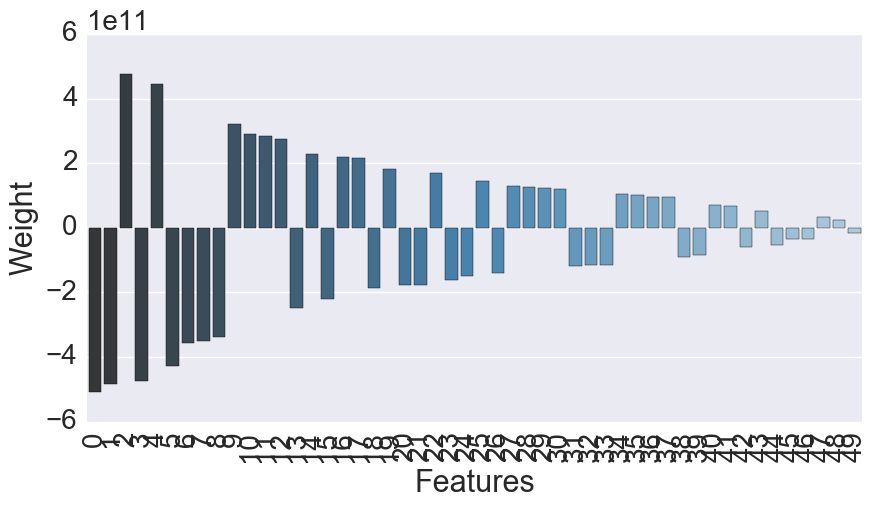

In [137]:
plt.close()
sns.set(font_scale=2)
fig,ax = plt.subplots(figsize=(10,5))
fig = sns.barplot(x = wts.index,
            y='Weight',
            data=wts.loc[abs(wts).sort_values('Weight',ascending = False).index],palette='Blues_d')
for item in fig.get_xticklabels():
    item.set_rotation(90)
sns.plt.xlabel('Features')
sns.plt.ylabel('Weight')
plt.show()

## Experimenting with a random forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [171]:
clf = RandomForestClassifier()
clf.fit(X_train_scl, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [145]:
clf.score(X_test_scl, y_test)

0.78365384615384615

In [146]:
rfoutput = kfold_feature_learning(X_train, X_test, y_train, y_test, clf = RandomForestClassifier(), search = False,
                                p_cutoff=None, problem = 'classification', folds = 3, output='light', 
                                scale=True, regcols = None, regdf = None, keep_cols = None, save_int = True)

running model for fold 1 of 3


AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

In [174]:
clf.feature_importances_

array([ 0.03712264,  0.00710063,  0.01312643,  0.00460981,  0.01729333,
        0.0092553 ,  0.02312061,  0.03222434,  0.00331026,  0.01451003,
        0.02402957,  0.01224223,  0.01878242,  0.00515767,  0.00771483,
        0.00975133,  0.00893427,  0.0525303 ,  0.00453729,  0.00525046,
        0.02393181,  0.0053919 ,  0.0175715 ,  0.01269398,  0.01534041,
        0.00374715,  0.01486216,  0.01655151,  0.07342547,  0.01145565,
        0.00254374,  0.02623145,  0.00674962,  0.01559161,  0.16134851,
        0.03068611,  0.00998341,  0.00648514,  0.00611011,  0.01024847,
        0.0095914 ,  0.10286029,  0.01048456,  0.01020354,  0.02940663,
        0.02546873,  0.00851094,  0.0053377 ,  0.00635158,  0.01023115])

In [179]:
clf.predict_proba(X_train_scl)[:,1]

array([ 0. ,  0. ,  0.2,  0. ,  0.1,  0. ,  0.2,  0.2,  0.1,  0. ,  0. ,
        0.1,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0.1,  0.1,  0. ,
        0. ,  0.2,  0.2,  0. ,  0. ,  1. ,  0. ,  0. ,  0.1,  0. ,  0.6,
        0.2,  0.3,  0.9,  0. ,  0.2,  0.1,  0. ,  0. ,  0.2,  0.1,  0. ,
        0. ,  0.1,  0.1,  0.2,  0.9,  0. ,  0.2,  0. ,  0.8,  0. ,  0. ,
        0. ,  0.9,  0.7,  0. ,  0.8,  0.8,  0. ,  0.1,  0.4,  0.9,  0.1,
        0.1,  0.8,  0. ,  0.6,  0. ,  0. ,  0. ,  0.3,  0.1,  0. ,  0. ,
        0. ,  1. ,  0.1,  0. ,  0.1,  0. ,  0.1,  0. ,  0.4,  0. ,  0. ,
        0. ,  0.2,  0.1,  0.1,  0. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ,
        0. ,  0. ,  0.2,  0. ,  0. ,  0. ,  0. ,  0.1,  0.5,  1. ,  0. ,
        0. ,  0.1,  0.1,  0. ,  0.9,  0.2,  0. ,  0.1,  0. ,  0.9,  0. ,
        0.5,  0.6,  0.2,  0.1,  0.2,  0. ,  0.2,  0.2,  0. ,  0. ,  0.2,
        1. ,  0.2,  0.1,  0. ,  0.1,  0.1,  0.1,  1. ,  0. ,  0. ,  0.9,
        0. ,  0. ,  0.7,  0. ,  1. ,  0.6,  0.3,  1

In [178]:
pandas.DataFrame(X_test).mean().values

0     0.294350
1     0.194540
2     0.223654
3     0.095454
4     0.044072
5     0.179285
6     0.225659
7     0.325395
8     0.317057
9     0.173201
10    0.220247
11   -0.057982
12    0.325205
13    0.185030
14    0.267216
15    0.220668
16    0.168340
17    0.240047
18    0.171923
19    0.256769
20    0.108450
21    0.277150
22    0.144265
23    0.258184
24    0.269643
25   -0.073784
26    0.141556
27    0.109919
28    0.231701
29    0.268874
30    0.295304
31    0.207377
32    0.146039
33    0.075175
34    0.202870
35    0.229928
36    0.181375
37   -0.033769
38    0.073831
39    0.103174
40    0.017915
41    0.177165
42    0.239264
43    0.331518
44    0.033400
45    0.298015
46    0.151211
47    0.166851
48    0.047869
49    0.162520
dtype: float64

In [166]:
xx.ravel().shape

(64232,)

In [167]:
yy.ravel().shape

(64232,)

In [170]:
clf.predict

array([[-2.30173745,  0.06802498],
       [-2.28173745,  0.06802498],
       [-2.26173745,  0.06802498],
       ..., 
       [ 3.55826255,  4.38802498],
       [ 3.57826255,  4.38802498],
       [ 3.59826255,  4.38802498]])

ValueError: query data dimension must match training data dimension